## Transaction Analysis

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

Read data from csv files into a pandas dataframe

In [21]:
comp_tran = pd.read_csv('C:/Users/Damie/OneDrive/Desktop/python_files/Trans_analysis/grad_competency_transactions.csv')
route = pd.read_csv('C:/Users/Damie/OneDrive/Desktop/python_files/Trans_analysis/grad_competency_user_startdate_route.csv')
product_lib = pd.read_csv('C:/Users/Damie/OneDrive/Desktop/python_files/Trans_analysis/grad_competency_product_library.csv')

Merge dataframes to create one dataframe 

In [26]:
all_dfs = route.merge(comp_tran, how='outer', left_on='user_id', right_on='history_user_id')
all_dfs = all_dfs.merge(product_lib, how='outer', left_on='history_product_id', right_on='id')

Lets take a look at the kind of data we have been provided with. 

In [40]:
print (all_dfs.columns)

Index(['user_id', 'min(us.`startdate`)', 'route_id', 'history_id',
       'history_user_id', 'history_date', 'history_product_id',
       'history_quantity', 'history_price', 'history_transaction_id',
       'history_transaction', 'id', 'category_id', 'name', 'start_dates_year',
       'start_dates_month', 'hist_year', 'hist_month'],
      dtype='object')


We have merged the dataframes above by joining the transaction data and the new user data at the columns history_user_id and user_id respectively, but we will keep both columns for clarity.

In [41]:
print (all_dfs.dtypes)

user_id                   float64
min(us.`startdate`)        object
route_id                  float64
history_id                float64
history_user_id           float64
history_date               object
history_product_id        float64
history_quantity          float64
history_price             float64
history_transaction_id    float64
history_transaction        object
id                        float64
category_id               float64
name                       object
start_dates_year           object
start_dates_month          object
hist_year                  object
hist_month                 object
dtype: object


By looking at the data types we can see we have a mix of categorical and numeric data types.

Now we need to create a connection object and query object for sqlite3 queries on the database.

In [27]:
e = pd.read_sql_query
conn = sqlite3.connect('C:/Users/Damie/OneDrive/Desktop/python_files/Trans_analysis/Trans_analysis.db')
all_dfs.to_sql('trans', conn, if_exists='replace', index=False)

Some data interrogation first to provide some context. Let's look at the time frame for the user_startdate database.

In [38]:
### Dates of the new startdate data
print (route.sort_values(by='min(us.`startdate`)').head(n=10))
print (route.sort_values(by='min(us.`startdate`)').tail(n=10))

       user_id min(us.`startdate`)  route_id
6048      9786          0000-00-00      40.0
8890     13879          0000-00-00       7.0
19848    32072          0000-00-00      39.0
0           22          2018-12-17       6.0
1           29          2018-12-31       4.0
3           32          2018-12-31       6.0
6           41          2019-01-11       7.0
8           44          2019-01-12       7.0
12          49          2019-01-13       3.0
9           46          2019-01-14       7.0
       user_id min(us.`startdate`)  route_id
21923    36524          2020-04-25      15.0
22501    37958          2020-04-26      12.0
22637    38296          2020-04-27      49.0
23181    39759          2020-04-27      47.0
22590    38193          2020-04-27      43.0
23079    39453          2020-04-28      44.0
22668    38375          2020-04-29      36.0
20714    33922          2020-05-05      60.0
11974    18243          2020-05-20      35.0
15121    23090          2020-06-01      71.0


The first user to sign up and first product delivery date is 17/12/2018 and the last user to sign up has a delivery date of 01/06/2020. So a sign up and delivery with some advance in the latter case.

Now we will provide a timeframe for the transaction data.

In [39]:
### Dates of the comp_tran data
print (comp_tran['history_date'].sort_values)

<bound method Series.sort_values of 0         2020-01-15
1         2020-01-15
2         2020-01-15
3         2020-01-15
4         2020-01-15
             ...    
589578    2020-04-14
589579    2020-04-14
589580    2020-04-14
589581    2020-04-14
589582    2020-04-14
Name: history_date, Length: 589583, dtype: object>


The earliest entry in this database is given as 15/01/2020 and the latest entry is 14/04/2020.

Perform string operation and create new columns for year and month. Then query the database to find the number of new customers per month per year.


In [28]:
all_dfs['start_dates_year'] = all_dfs['min(us.`startdate`)'].str[:-6]
all_dfs['start_dates_month'] = all_dfs['min(us.`startdate`)'].str[5:-3]

all_dfs.to_sql('trans', conn, if_exists='replace', index=False)

print (all_dfs.columns)

new_cust = e('''
             
                 SELECT COUNT(DISTINCT user_id) AS total, start_dates_year AS Year, start_dates_month
                 FROM trans
                 WHERE start_dates_year NOT LIKE '0000'
                 GROUP BY start_dates_month, start_dates_year
                 
                 ''', conn)

Index(['user_id', 'min(us.`startdate`)', 'route_id', 'history_id',
       'history_user_id', 'history_date', 'history_product_id',
       'history_quantity', 'history_price', 'history_transaction_id',
       'history_transaction', 'id', 'category_id', 'name', 'start_dates_year',
       'start_dates_month'],
      dtype='object')


Text(24.843717447916667, 0.5, 'Number of Customers')

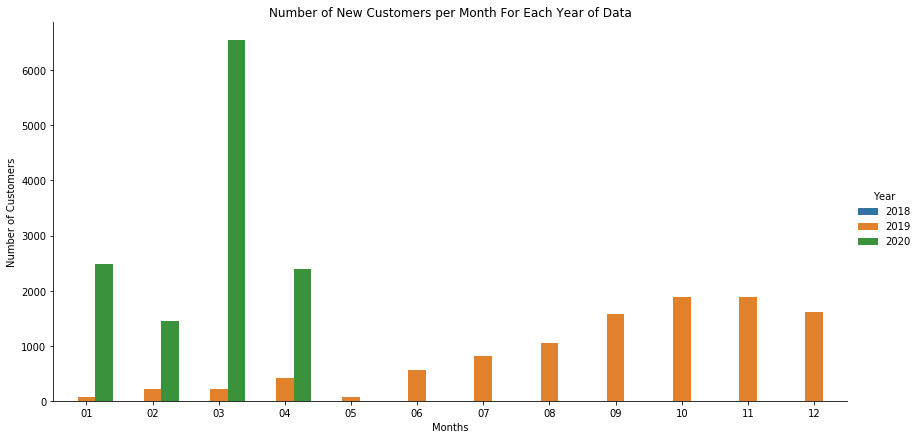

In [30]:
chart = sns.catplot(x='start_dates_month', y='total', hue='Year', kind='bar',data=new_cust, height=6, aspect=2)
plt.title('Number of New Customers per Month For Each Year of Data')
plt.xlabel('Months')
plt.ylabel('Number of Customers')

The company was founded in 2018 so we can expect few subscriptions before the company builds it's reputation. Throughout 2019 we see a steady increase in new customers month by month. Of particular interest is the surge of new customers in March of 2020, likely due to the lockdown effect and people tending towards home deliveries.

Let's investigate the retention rate of customers by looking at all customers at the the time of their start date and the percentage of which currently have or have had an order between Jan and April 2020.

In [34]:
all_dfs['hist_year'] = all_dfs['history_date'].str[:-6]
all_dfs['hist_month'] = all_dfs['history_date'].str[5:-3]

all_dfs.to_sql('trans', conn, if_exists='replace', index=False)

repeat_cust = e('''
                
                    SELECT COUNT(DISTINCT user_id) as CR, history_transaction_id, start_dates_year, start_dates_month
                    FROM trans
                    WHERE history_transaction_id IS NULL 
                    AND start_dates_year NOT IN ('2020', '0000')
                    GROUP BY start_dates_year, start_dates_month
                   
                    ''',conn)

#cust_rent = 


total_new_cust = e('''
             
                 SELECT COUNT(DISTINCT user_id) AS total, start_dates_year AS Year, start_dates_month
                 FROM trans
                 WHERE start_dates_year NOT IN ('0000', '2020')
                 GROUP BY start_dates_year, start_dates_month
                 
                 ''', conn)
                 
repeat_cust['percent'] = (repeat_cust['CR'] / total_new_cust['total'])*100
repeat_cust['percent'] = 100 - repeat_cust['percent']

Text(25.491876446759264, 0.5, 'Customer Still Using Service [%]')

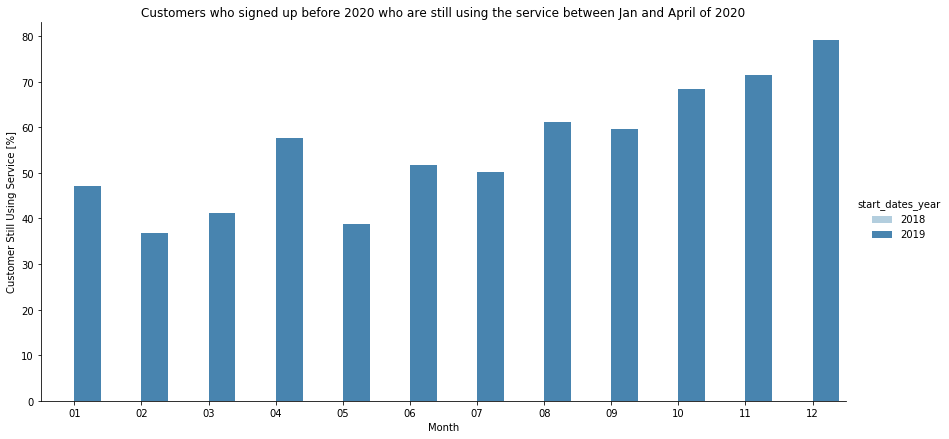

In [35]:
### Plot of customers who signed up before 2020 who are using the service between Jan and April of 2020
chart = sns.catplot(x='start_dates_month', y='percent', hue='start_dates_year', kind = 'bar', data=repeat_cust,  palette="Blues",
                   height=6, aspect=2)
plt.title('Customers who signed up before 2020 who are still using the service between Jan and April of 2020')
plt.xlabel('Month')
plt.ylabel('Customer Still Using Service [%]')

We find that the three customers who signed up in December 2018 don't currently have an order placed between Jan and April of 2020. Overall there is general increasing trend in the number of customers who signed up in 2019 and are still using the service inbetween Jan and April of 2020. Compared with the figure above, not only do we see an increasing number of new customers it is also concurrent with an increasing retention rate.

In [45]:
cust_order = e('''
               
                   SELECT COUNT (DISTINCT history_user_id)
                   FROM trans

                   
                   
                   ''', conn)
print (cust_order)      
print ((all_dfs['history_quantity'].sum()))      
print ('Average number of items per customer', (all_dfs['history_quantity'].sum() / cust_order)  )    

   COUNT (DISTINCT history_user_id)
0                             19020
948578.0
Average number of items per customer    COUNT (DISTINCT history_user_id)
0                          49.87266


Above, we see the number of unique customers in the transaction data and the sum of all the items sold, thus giving an average of items per customer. Although further analysis is not given here due to time constraints, we would find a smaller number of customers ordering more regularly than others.

Next we query the database to find the frequency of each product per route.

In [37]:
product_route = e('''
                  
                      SELECT route_id, SUM(history_quantity) AS total, name
                      FROM trans
                      WHERE route_id IS NOT NULL
                      AND name IS NOT NULL
                      AND history_quantity IS NOT NULL
                      GROUP BY route_id, history_product_id
                      ORDER BY 'total'                       
                                             
                    ''', conn)


product_route = product_route.pivot('route_id','name','total')
product_route = product_route.fillna(0)
product_route.sort_index(level=0, ascending=True, inplace=True)

We will use tableau to create the next figure as we anticipate interactivity of a dashboard will help provide a far more powerful analysis than a static graph for the next task. We will export the dataframe to excel and connect Tableau to the excel file.

In [42]:
product_route.to_excel('heat_map.xlsx', index=True)

In [36]:
%%HTML
<div class='tableauPlaceholder' id='viz1587128990494' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;Product_route&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Product_route&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Pr&#47;Product_route&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1587128990494');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.maxWidth='2000px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='1127px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.maxWidth='2000px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';vizElement.style.maxHeight='1127px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [46]:
routes_products = e('''
                  
                      SELECT COUNT(DISTINCT route_id) AS R, COUNT(DISTINCT id) AS P
                      FROM trans
                                   
                             ''', conn)

print ('Number of routes', routes_products['R'], 'Number of different products sold', routes_products['P'])

Number of routes 0    81
Name: R, dtype: int64 Number of different products sold 0    57
Name: P, dtype: int64


Currently, the company sells 57 different products across 81 different routes.